TODO: Small description for notebook

## <span style="color:black">Mount drive to notebook</span>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## <span style="color:black">Install needed packages</span>

In [1]:
!pip install tld
!pip install pandas==1.0.5

import os
import bz2
import json
import glob
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from utils import process_chunk, process_text, manual_extraction, ids_to_tweets, embedSentence, embedding, averageEmbedding, featurize

#Packages for url parsing
import tld
from tld import get_tld
import requests
from urllib.request import urlopen
from bs4 import BeautifulSoup
from urllib.request import urlopen
#Packages for NLP methods
import re
import nltk
import gensim
from gensim import models
from gensim import corpora
import gensim.downloader as api
from gensim.test.utils import datapath, common_texts
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
# We need this dataset in order to use the tokenizer
nltk.download('punkt')
# Also download the list of stopwords to filter out
nltk.download('stopwords')
stemmer = PorterStemmer()

# Add constants/paths
_DATASETS_PATHS = '/content/drive/Shareddrives/ADA LUNATICS 2021/datasets'

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## <span style="color:Blue">1) Load Datasets</span>

In [ ]:
# Save the datasets paths
quote_datasets = sorted(glob.glob(_DATASETS_PATHS+'/Quotebank/*.bz2'))
quote_datasets

['/content/drive/Shareddrives/ADA LUNATICS 2021/datasets/Quotebank/quotes-2015.json.bz2',
 '/content/drive/Shareddrives/ADA LUNATICS 2021/datasets/Quotebank/quotes-2016.json.bz2',
 '/content/drive/Shareddrives/ADA LUNATICS 2021/datasets/Quotebank/quotes-2017.json.bz2',
 '/content/drive/Shareddrives/ADA LUNATICS 2021/datasets/Quotebank/quotes-2018.json.bz2',
 '/content/drive/Shareddrives/ADA LUNATICS 2021/datasets/Quotebank/quotes-2019.json.bz2',
 '/content/drive/Shareddrives/ADA LUNATICS 2021/datasets/Quotebank/quotes-2020.json.bz2']

### <span style="color:red"><div style="text-align: justify">In order to deal with extremely large data we decided chunking the data and apply all the processing and data wrangling steps on chunks then combine the chunk results (inspired by this [article](https://towardsdatascience.com/3-simple-ways-to-handle-large-data-with-pandas-d9164a3c02c1))</div></span>

In [ ]:
#Iterate through years dataset then create an iterator to process chunks of 1M rows at a time
num_quotes_per_year = {}
for dataset in quote_datasets:
    data_name = os.path.basename(dataset).split('-')[1]
    num_quotes_per_year[data_name] = 0
    df_reader = pd.read_json(dataset, lines=True, compression='bz2', chunksize=500000)
    print('Processing Data:', data_name)
    for chunk in df_reader:
        num_quotes_per_year[data_name] += len(chunk)
    print(f'About {num_quotes_per_year[data_name]} in {data_name}')

Processing Data: 2015.json.bz2
About 20874338 in 2015.json.bz2
Processing Data: 2016.json.bz2
About 13862129 in 2016.json.bz2
Processing Data: 2017.json.bz2
About 26611588 in 2017.json.bz2
Processing Data: 2018.json.bz2
About 27228451 in 2018.json.bz2
Processing Data: 2019.json.bz2
About 21763302 in 2019.json.bz2
Processing Data: 2020.json.bz2
About 5244449 in 2020.json.bz2


In [ ]:
with open('/content/drive/Shareddrives/ADA LUNATICS 2021/datasets/dict.json') as f:
  num_quotes_per_year = json.load(f)

In [ ]:
dataset = {'year': [i.split('.')[0]for i in list(num_quotes_per_year.keys())],
           'num_quotes': list(num_quotes_per_year.values())}
df_quotes = pd.DataFrame(dataset)
df_quotes

,year,num_quotes
0,2015,20874338
1,2016,13862129
2,2017,26611588
3,2018,27228451
4,2019,21763302
5,2020,5244449


Text(0, 0.5, '# of Quotes')

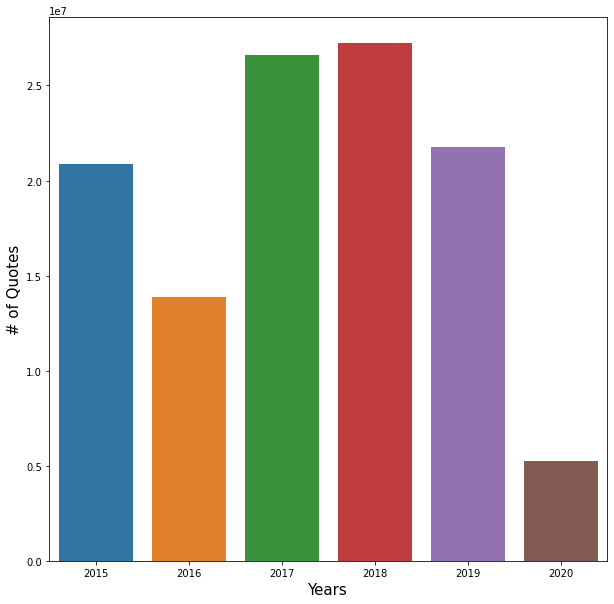

In [ ]:
#Visualize number of quotes per year
_, axis = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
ax = sns.barplot(x="year", y="num_quotes", data=df, capsize=.5, ax=axis)
ax.set_xlabel('Years', fontsize=15)
ax.set_ylabel('# of Quotes', fontsize=15)

## <span style="color:Blue">2) Topic Analysis</span>

### <span style="color:Red"><div style="text-align: justify">After loading the data, we need to extract the targeted quotes from the dataset that will be used in our project. Thus, there are three methods to do so explained below.</div></span>

### <span style="color:green">A- Manual Extraction Method</span>

#### <span style="color:purple"><div style="text-align: justify">This method is a naive one which means extracting the rows that their quotes include specific keywords. Accordingly, in order to compile a more thorough keywords, we investigated a couple of articles/papers concerning sexual harassement movements such as MeToo such as: [article 1](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6751092/)</div></span>

#### <span style="color:purple"><div style="text-align: justify"> Then, we decided to filter the dataset from 2015-2020 with one keyword (metoo) and from the resulted quotes we built a word cloud using [WordCloud Library](https://amueller.github.io/word_cloud/) to select the top 20 keywords mentioned in these quotes and pick the relevant ones. Also, we added keywords from this [website](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/2SRSKJ) and this [article](https://journals.sagepub.com/doi/10.1177/1940161220968081) to end up at the end with 15 keywords.</div></span>

In [ ]:
#Iterate through all datasets and extract the quotes containing metoo
for dataset in quote_datasets:
    df_reader = pd.read_json(dataset, lines=True, compression='bz2', chunksize=500000)
    print('Processing Data:', os.path.basename(dataset))
    for chunk in df_reader:
        chunk = process_chunk(chunk, manual_extraction, keywords_quotes_path)

#### <span style="color:purple"><div style="text-align: justify"> The results of the above cell is saved in the path mentioned below.</div></span>

In [ ]:
me_too_quotes_path = '/content/drive/Shareddrives/ADA LUNATICS 2021/datasets/metoo-extracted-quotes.csv.bz2'

In [ ]:
#Load the saved results from previous cell
warnings.simplefilter(action='ignore', category=FutureWarning)
df = pd.read_csv(me_too_quotes_path)
df.drop(df[df == 'quotation'].index)
df = df.drop(columns='Unnamed: 0')
print(f'The number of quotes that contain metoo: {len(df)}')
df.head(10)

The number of quotes that contain metoo: 1270


,quotation
0,This important study will help Eabametoong Fir...
1,The real #metoo video is finally up! Missed th...
2,Might have fell down... but I KILLLED that shI...
3,The real #metoo video is finally up! Missed th...
4,The real #metoo is finally up! Missed that bas...
5,The real #metoo video is finally up!
6,Might have fell down... but I KILLLED that [ e...
7,We're shocked by @stassi's comments re the #me...
8,"The #metoo movement is growing daily, as high-..."
9,When people like me are wrongfully accused by ...


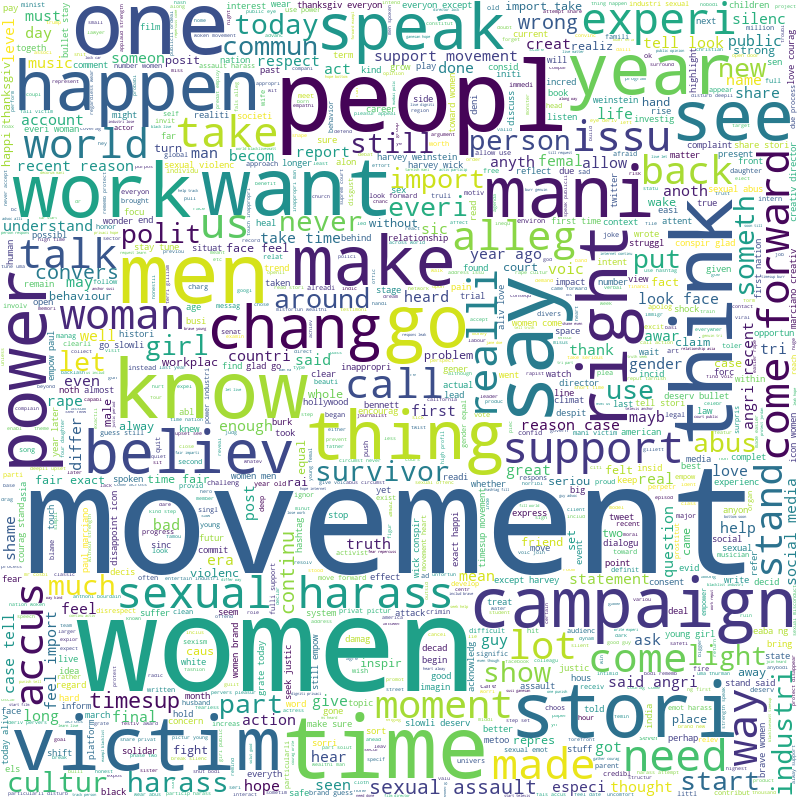

In [ ]:
#Create a word cloud from the extracted quotes
df = df.quotation.str.replace('metoo', ' ')
#Process texts in quotes
cleaned_text = df.apply(process_text)
#Join the different processed titles together.
long_string = ','.join([text for text_list in cleaned_text.values for text in text_list])
#Create a WordCloud object
wordcloud = WordCloud(width = 800, height = 800, background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')
#Generate a word cloud
wordcloud.generate(long_string)
#Visualize the word cloud
wordcloud.to_image()

In [ ]:
#Filter the top words from word cloud using an arbitrarily threshold then sort them
filtered_words = dict()
#Iterate over all the items in dictionary
for (key, value) in wordcloud.words_.items():
    #Check if item satisfies the given condition then add to new dict
    #Set an arbitrarily value to shorten the list
    if value >= 0.15:
        filtered_words[key] = value
sorted_words = dict(sorted(filtered_words.items(), key=lambda kv: kv[1], reverse=True))

Text(0, 0.5, 'Mentions Ratio')

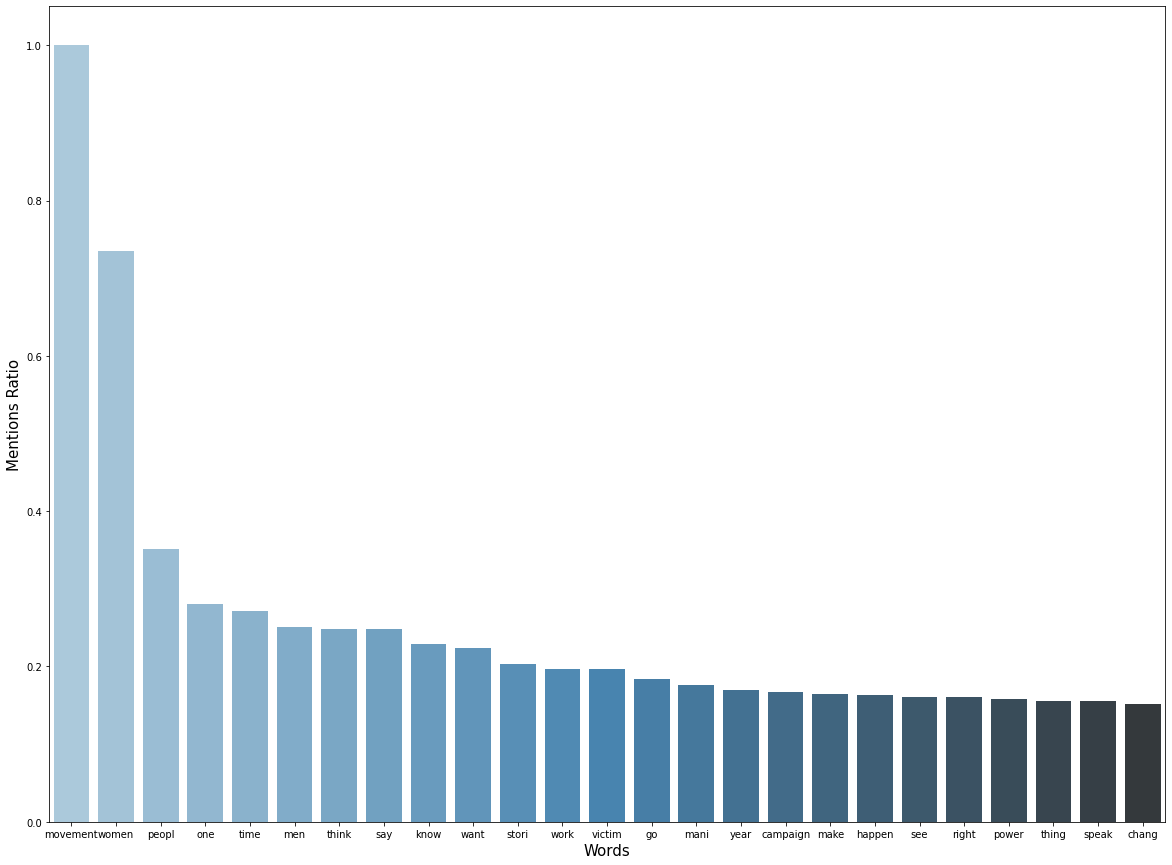

In [ ]:
#Visualize the mentions of the words generated from word cloud
words = pd.DataFrame({'words': list(sorted_words.keys()), 'mentions ratio': list(sorted_words.values())})
_, axis = plt.subplots(nrows=1, ncols=1, figsize=(20,15))
ax = sns.barplot(x="words", y="mentions ratio", data=words, capsize=.5, ax=axis, palette="Blues_d")
ax.set_xlabel('Words', fontsize=15)
ax.set_ylabel('Mentions Ratio', fontsize=15)
#Modify xticks size

In [ ]:
#The final keywords compiled
keywords = ['movement', 'women', 'victim', 'campaign', 'sex', 'harass', 'assualt',
           'rape', 'misconduct', 'metoo', 'timesup', 'abuse', 'workplace', 'right', 'femin']
#Save the results from keywords extraction in this path
keywords_quotes_path = '/content/drive/Shareddrives/ADA LUNATICS 2021/datasets/keywords-extracted-data.csv.bz2'

In [ ]:
#Iterate through all datasets and extract the quotes containing any of the keywords selected
for dataset in quote_datasets:
    df_reader = pd.read_json(dataset, lines=True, compression='bz2', chunksize=500000)
    print('Processing Data:', os.path.basename(dataset))
    for chunk in df_reader:
        chunk = process_chunk(chunk, manual_extraction, keywords, keywords_quotes_path)

Processing Data: quotes-2015.json.bz2
Processing chunk with 500000 rows
There are 27052 rows that include some of the keywords
Processing chunk with 500000 rows
There are 27247 rows that include some of the keywords
Processing chunk with 500000 rows
There are 27124 rows that include some of the keywords
Processing chunk with 500000 rows
There are 27034 rows that include some of the keywords
Processing chunk with 500000 rows
There are 26961 rows that include some of the keywords
Processing chunk with 500000 rows
There are 27092 rows that include some of the keywords
Processing chunk with 500000 rows
There are 27088 rows that include some of the keywords
Processing chunk with 500000 rows
There are 27054 rows that include some of the keywords
Processing chunk with 500000 rows
There are 26980 rows that include some of the keywords
Processing chunk with 500000 rows
There are 27124 rows that include some of the keywords
Processing chunk with 500000 rows
There are 27160 rows that include some

In [ ]:
#Load the manually extracted data based on keywords
df = pd.read_csv(keywords_quotes_path, compression='bz2')
df = df.drop(df[df['quotation'] == 'quotation'].index)
df = df.drop(columns='Unnamed: 0')
print(f'The number of quotes that contain some of the selected keywords: {len(df)}')
df.head(10)

The number of quotes that contain some of the selected keywords: 6625708


,quoteID,quotation,speaker,qids,date,probas,urls
0,2015-08-31-000271,... a great day for veterans here in Littleton...,Jeanne Shaheen,['Q270316'],2015-08-31 02:10:00,"[['Jeanne Shaheen', '0.742'], ['None', '0.2359...",['http://www.unionleader.com/article/20150831/...
1,2015-10-29-035215,how the greatest movement came into being and ...,None,[],2015-10-29 21:25:14,"[['None', '0.5458'], ['Paul Hawken', '0.4542']]",['https://medium.com/enspiral-tales/bioneers-d...
2,2015-10-25-000242,"' It is not now, nor has it ever been, the gol...",Bernie Sanders,['Q359442'],2015-10-25 14:12:35,"[['Bernie Sanders', '0.5395'], ['None', '0.312...",['http://examiner.com/article/bernie-sanders-s...
3,2015-10-17-000460,[ This is ] defamation. I'm hitting back. [ Me...,Meghan King Edmonds,['Q20684375'],2015-10-17 13:35:01,"[['Meghan King Edmonds', '0.7414'], ['None', '...",['http://www.inquisitr.com/2500312/vicki-gunva...
4,2015-09-04-030275,I ain't going nowhere. I'm going to be right h...,Letroy Guion,['Q13219370'],2015-09-04 12:36:42,"[['Letroy Guion', '0.7119'], ['None', '0.2804'...",['http://www.channel3000.com/sports/packers/Pa...
5,2015-12-01-033189,"I am confident enough, optimistic enough to sa...",Frank-Walter Steinmeier,['Q76658'],2015-12-01 08:47:00,"[['Frank-Walter Steinmeier', '0.6923'], ['Mr H...",['http://express.co.uk/news/politics/623296/EU...
6,2015-02-03-000382,A careful analysis of the career histories of ...,Lisa Mainiero,['Q53121229'],2015-02-03 17:22:00,"[['Lisa Mainiero', '0.9511'], ['None', '0.0489']]",['http://www.forbes.com/sites/bonniemarcus/201...
7,2015-01-27-023512,I am honored and proud to raise awareness for ...,Joe Haden,['Q733737'],2015-01-27 13:25:00,"[['Joe Haden', '0.5859'], ['None', '0.3302'], ...",['http://www.istockanalyst.com/article/viewart...
8,2015-09-10-001454,"A couple bumps and bruises, but all right.",James Blake,"['Q350362', 'Q53333']",2015-09-10 06:31:35,"[['James Blake', '0.7538'], ['None', '0.2422']...",['http://rss.cnn.com/c/35494/f/676993/s/49bd29...
9,2015-09-23-032351,I am proud that once again I got to fly the So...,President Barack Obama,['Q76'],2015-09-23 06:04:06,"[['President Barack Obama', '0.6547'], ['None'...",['http://www.bdlive.co.za/business/management/...


In [ ]:
#Extract the Year-Month from the date column to plot a timeline of the selected quotes
df['y-m'] = df['date'].apply(lambda x: x[:7])
quotes_timeline = df[['y-m', 'quotation']].groupby(['y-m'], as_index=False)['quotation'].count()
quotes_timeline.head()

,y-m,quotation
0,2015-01,87584
1,2015-02,88268
2,2015-03,102218
3,2015-04,83233
4,2015-05,62275


In [ ]:
df['year'] = df['date'].apply(lambda x: x[:4])
quotes_timeline = df[['year', 'quotation']].groupby(['year'], as_index=False)['quotation'].count()
quotes_timeline.head()

,year,quotation
0,2015,1129612
1,2016,775557
2,2017,1507517
3,2018,1618392
4,2019,1290204


Text(0, 0.5, '# of Quotes')

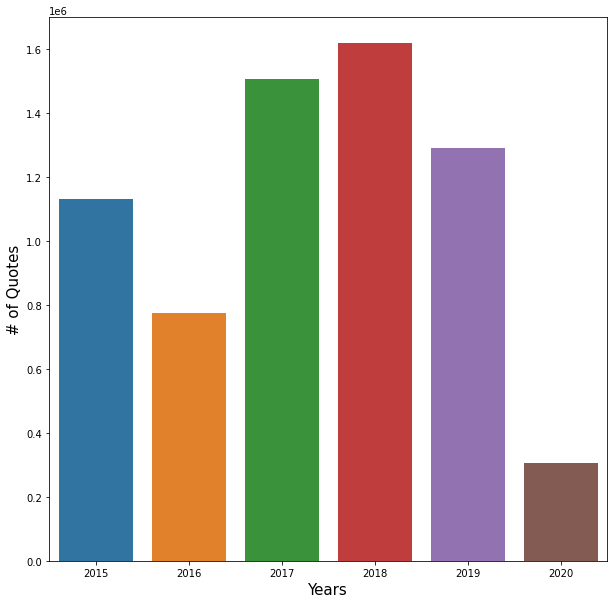

In [ ]:
#Visualize number of quotes per year
_, axis = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
ax = sns.barplot(x="year", data=quotes_timeline, capsize=.5, ax=axis)
ax.set_xlabel('Years', fontsize=15)
ax.set_ylabel('# of Quotes', fontsize=15)

Text(0, 0.5, '# of Quotes')

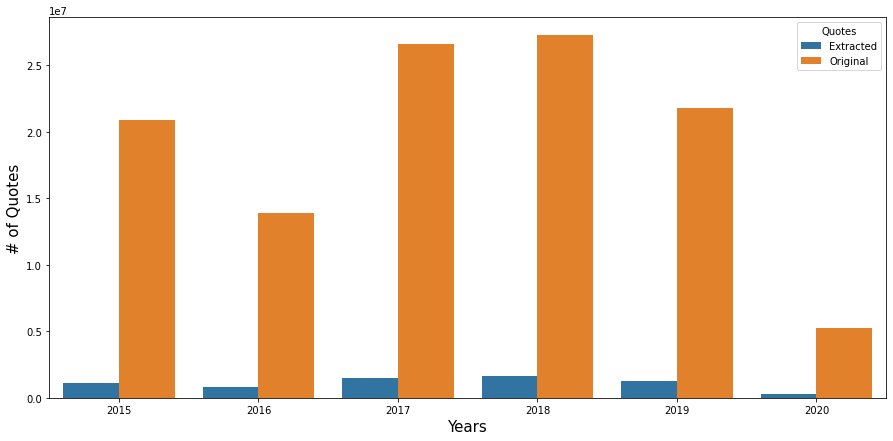

In [ ]:
#Compare the barplots of unfiltered vs filtered quotes
merged_df = pd.merge(quotes_timeline, df_quotes, on="year")
merged_df.rename(columns={'quotation': 'Extracted', 'num_quotes': 'Original'}, inplace=True)
test_data_melted = pd.melt(merged_df, id_vars='year',\
                           var_name="Quotes", value_name="value_numbers")
#Visualize number of quotes per year
_, axis = plt.subplots(nrows=1, ncols=1, figsize=(15,7))
ax = sns.barplot(x="year", y="value_numbers", hue='Quotes', data=test_data_melted, capsize=.5, ax=axis)
ax.set_xlabel('Years', fontsize=15)
ax.set_ylabel('# of Quotes', fontsize=15)

#### <span style="color:purple"><div style="text-align: justify"> The final results of the *Manual Extraction Step* is manifested in the timeline plotted below of the number of extracted quotes across time.</div></span>

Text(0, 0.5, '# of Quotations')

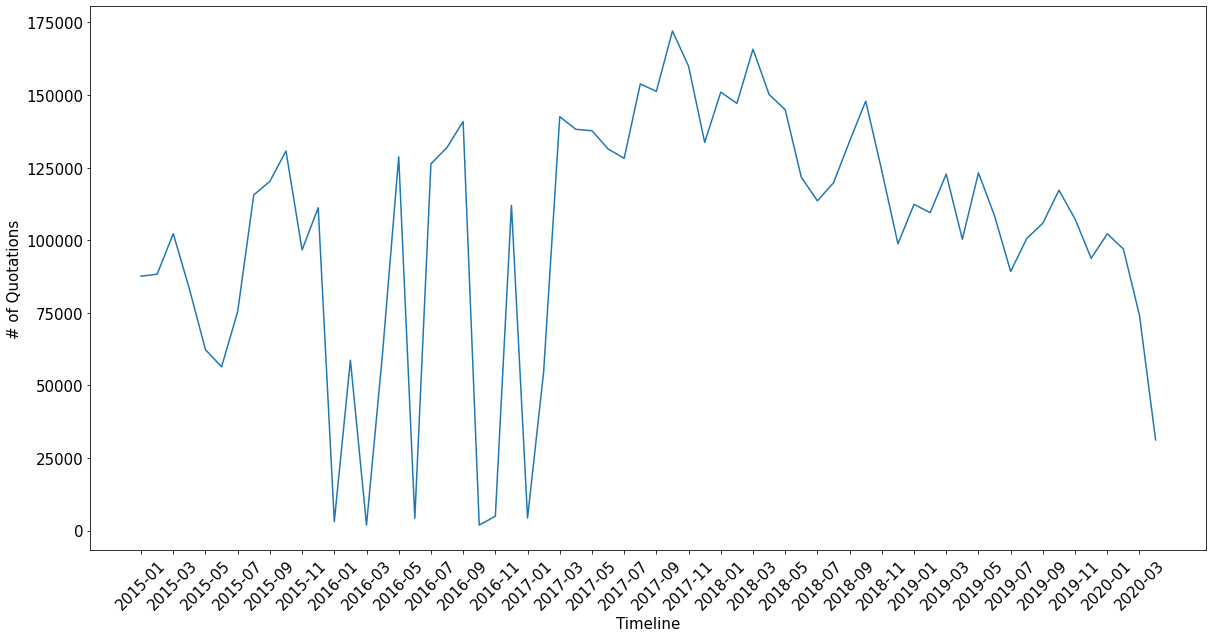

In [ ]:
#Visualizing the number of quotes throughout time
_, axis = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
ax = sns.lineplot(x='y-m', y='quotation', data=quotes_timeline, ax=axis)
ax.set_xticks(quotes_timeline['y-m'][::2])
ax.set_xticklabels(quotes_timeline['y-m'][::2], rotation=45)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Timeline', fontsize=15)
ax.set_ylabel('# of Quotations', fontsize=15)

#### <span style="color:purple"><div style="text-align: justify"> To account for the variation of quotes across the days of each month. We plotted the mean of quotes in each month in addition to showing the 95% confidence interval</div></span>

In [ ]:
#Extract the day from the date column
df['day'] = df['date'].apply(lambda x: x[8:10])
quotes_timeline = df[['y-m', 'day', 'quotation']].groupby(['y-m','day'], as_index=False)['quotation'].count()
quotes_timeline.head()

,y-m,day,quotation
0,2015-01,01,1312
1,2015-01,02,1924
2,2015-01,03,1319
3,2015-01,04,1382
4,2015-01,05,2501


Text(0, 0.5, '# of Quotations')

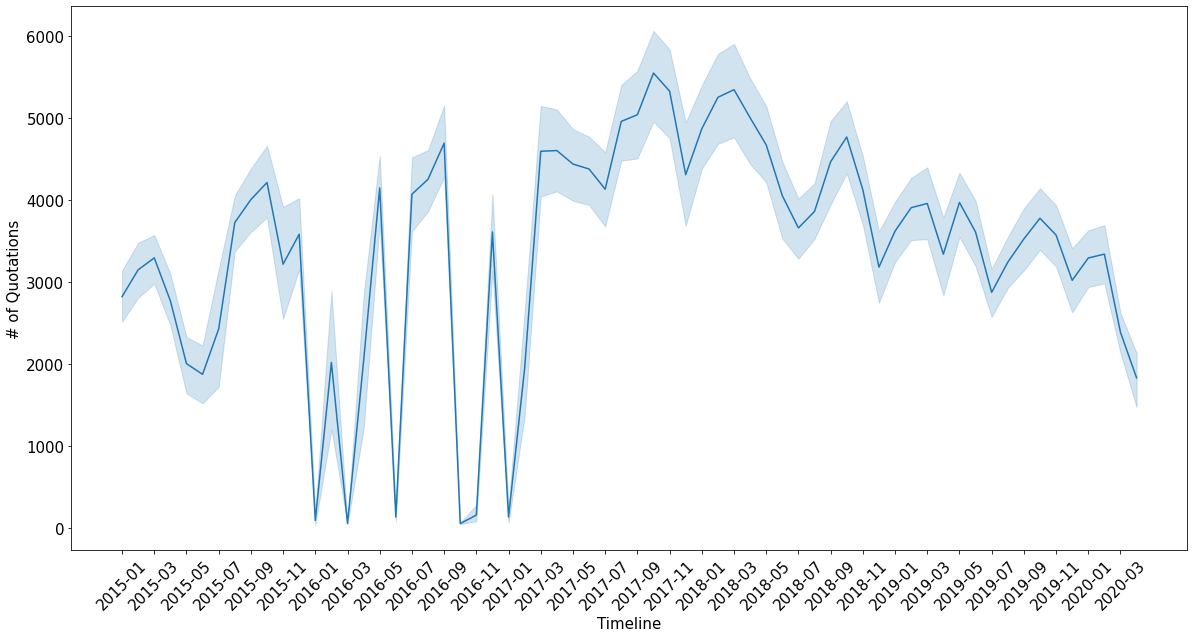

In [ ]:
_, axis = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
ax = sns.lineplot(x='y-m', y='quotation', data=quotes_timeline, ax=axis)
ax.set_xticks(np.sort(df['y-m'].unique())[::2])
ax.set_xticklabels(np.sort(df['y-m'].unique())[::2], rotation=45)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Timeline', fontsize=15)
ax.set_ylabel('# of Quotations', fontsize=15)

---

### <span style="color:green">B- Parsing URLs Method</span>

#### <span style="color:purple"><div style="text-align: justify">This method would help filter quotes based on the article title which would be extracted from the urls. First, we will extract the hostnames of the urls. Then, pick the top 10 hostnames in terms of occurences, as an example, and extract their titles to hand-pick the relevent titles.</div></span>

In [ ]:
#Load the urls and titles parsed in the manually extracted data based on keywords
df_hostnames = pd.read_csv('/content/drive/Shareddrives/ADA LUNATICS 2021/datasets/urls_hostnames_keywords-extracted-quotes.csv.bz2', compression='bz2')

In [ ]:
df_hostnames.head()

,Unnamed: 0,urls,host name
0,0.0,['http://www.unionleader.com/article/20150831/...,http://www.unionleader.com/
1,1.0,['https://medium.com/enspiral-tales/bioneers-d...,https://medium.com/
2,2.0,['http://examiner.com/article/bernie-sanders-s...,http://examiner.com/
3,3.0,['http://www.inquisitr.com/2500312/vicki-gunva...,http://www.inquisitr.com/
4,4.0,['http://www.channel3000.com/sports/packers/Pa...,http://www.channel3000.com/


In [ ]:
#Load the urls and titles parsed in the manually extracted data based on keywords
df_titles = pd.read_csv('/content/drive/Shareddrives/ADA LUNATICS 2021/datasets/urls_hostnames_titles_keywords-extracted-quotes.csv.bz2', compression='bz2')
df_titles

---

### <span style="color:green">C- NLP-based Method</span>

#### <span style="color:purple"><div style="text-align: justify">The quotes extracted so far could some of them still not be related to *Sexual Harassment* (as shown below for an example). Hence, in this step, we will explore different NLP-based methods to properly perform *Topic Modeling* and only save the related quotes to our project</div></span>

#### <span style="color:purple"><div style="text-align: justify">Below are the methods explored, the reason why we used them and sample of the results. But first let's apply some basic NLP preprocessing to prepare the quotes, including:</div></span>

##### <span style="color:orange">
- Tokenization using *NLTK*.
- Removing *Stop Words*
- Removing *Punctuation Symbols*
- Stemming words to their roots
</span>

#### <span style="color:purple"><div style="text-align: justify">After applying preprocessing on the manually extracted quotes, save the new format *(List of words)* in a pickle file.</div></span>

In [2]:
#Path for saved list of words
save_pickle_file = _DATASETS_PATHS+'/lists_of_words.pkl'

In [ ]:
#Read the extracted quotes as chunck of 0.5M to preprocess them
quotes_list = []
df_reader = pd.read_csv(keywords_quotes_path, compression='bz2', chunksize=500000)
print('Processing Data:', os.path.basename(dataset))
for chunk in df_reader:
  #Open pickle file in append mode
  with open(save_pickle_file, 'ab') as f:
    chunk = chunk.drop(chunk[chunk == 'quotation'].index)
    chunk = chunk.drop(columns='Unnamed: 0')
    pickle.dump(process_chunk(chunk), f)

Processing Data: keywords-extracted-quotes.csv.bz2


/usr/local/lib/python3.7/dist-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


Processing chunk with 500000 rows
Index(['quotation'], dtype='object')
Processing chunk with 500000 rows
Index(['quotation'], dtype='object')
Processing chunk with 500000 rows
Index(['quotation'], dtype='object')
Processing chunk with 500000 rows
Index(['quotation'], dtype='object')
Processing chunk with 500000 rows
Index(['quotation'], dtype='object')
Processing chunk with 500000 rows
Index(['quotation'], dtype='object')
Processing chunk with 500000 rows
Index(['quotation'], dtype='object')
Processing chunk with 500000 rows
Index(['quotation'], dtype='object')
Processing chunk with 500000 rows
Index(['quotation'], dtype='object')
Processing chunk with 500000 rows
Index(['quotation'], dtype='object')
Processing chunk with 500000 rows
Index(['quotation'], dtype='object')
Processing chunk with 500000 rows
Index(['quotation'], dtype='object')
Processing chunk with 500000 rows
Index(['quotation'], dtype='object')
Processing chunk with 125941 rows
Index(['quotation'], dtype='object')


In [3]:
#Load the saved pickle file
list_words = list(pd.read_pickle(save_pickle_file))

In [ ]:
#Sample
list_words[10]

['journey',
 'space',
 'captur',
 'one',
 'singl',
 'shot',
 'show',
 'subtl',
 'push',
 'pull',
 'masculin',
 'feminin']

#### <span style="color:magenta">1- LDA *(Latent Dirichlet Allocation)*</span>

##### <span style="color:orange"><div style="text-align: justify">We explored this method because LDA tries to map all the text data to the (unknown) topics in a way such that the words in each quote are mostly captured by those topics. The fundamental assumption here is that quotes with the same topic will use similar words. It's also assumed that every quote is composed of a mixture of topics, and every word has a probability of belonging to a certain topic.</div></span>

In [ ]:
#Create a Gensim dictionary from the data using the bag of words model
dictionary = corpora.Dictionary(list_words)
corpus = [dictionary.doc2bow(word) for word in list_words]
model = models.ldamodel.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)

In [ ]:
#Save trained model to disk.
temp_file = datapath("model")
model.save(temp_file)

In [ ]:
#Create a corpus from a list of texts
common_dictionary = corpora.Dictionary(common_texts)
common_corpus = [common_dictionary.doc2bow(text) for text in common_texts]
#Train the model on the corpus.
lda = models.ldamodel.LdaModel(common_corpus, num_topics=10)

In [ ]:
topics = model.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.041*"women" + 0.015*"like" + 0.014*"peopl" + 0.011*"men"')
(1, '0.025*"victim" + 0.016*"abus" + 0.011*"sexual" + 0.009*"famili"')
(2, '0.078*"right" + 0.025*"go" + 0.023*"get" + 0.016*"think"')
(3, '0.015*"campaign" + 0.013*"new" + 0.011*"work" + 0.010*"women"')
(4, '0.044*"right" + 0.011*"campaign" + 0.011*"state" + 0.011*"peopl"')


#### <span style="color:magenta">2- Word2Vec Model</span>

##### <span style="color:orange"><div style="text-align: justify">A different way to investigate topics is to extract word embeddings and train a model on these embeddings to detect similarities.</div></span>

In [ ]:
#Train word2vec on list of words
model = models.Word2Vec(list_words, min_count=1,size= 100,workers=3, window =3, sg = 1)

In [ ]:
#Print the top 5 similar words to harass (cosine similarity)
model.most_similar('harass', topn=5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('intimid', 0.8215645551681519),
 ('retali', 0.7891688942909241),
 ('bulli', 0.7701835632324219),
 ('victimis', 0.7539269924163818),
 ('stalk', 0.7376947402954102)]

#### <span style="color:magenta">3- GloVe Model</span>

##### <span style="color:orange"><div style="text-align: justify">Here, we use another word embedding method and we used a pre-trained model*‘glove-wiki-gigaword-300’* which is a model learned using GloVe on the wikipedia and gigaword corpuses with an embedding size of 300.</div></span>

In [4]:
#Save the list of words in a dataframe to process them
embeddedDF = pd.DataFrame({'scentences': list_words})
dataDF = embeddedDF.copy()
embeddedDF.head()

,scentences
0,"[great, day, veteran, littleton, across, north..."
1,"[greatest, movement, came, one, saw, come]"
2,"[ever, gold, standard, trade, agreement, sande..."
3,"[defam, hit, back, meghan, chanc, make, right,..."
4,"[go, nowher, go, right, green, bay, green, bay..."


In [5]:
#Load pretrained model
word_vectors = api.load('glove-wiki-gigaword-300')

In [6]:
#Extract word embeddings
embeddedDF['scentences'] = embeddedDF['scentences'].apply(lambda x: embedSentence(x, word_vectors))
#Will be useful later for combining dataframes
keepIndices = embeddedDF.index
#Average the embeddings of words in one scentence
embeddedDF['scentences'] = embeddedDF['scentences'].apply(averageEmbedding)

In [7]:
embeddedDF.index = list(range(0, len(embeddedDF)))
embeddedDF.head()

,scentences
0,"[-0.026508026, 0.03706931, 0.006902222, -0.178..."
1,"[0.057423335, 0.053511336, -0.12297001, -0.084..."
2,"[-0.12058276, -0.00594178, 0.024895065, -0.061..."
3,"[0.16207139, -0.109700255, -0.23056835, -0.235..."
4,"[0.042109244, -0.16742308, -0.053067572, -0.14..."


In [8]:
#Put every feature in one column to perform clustering later
FeatureColumns = []
for i in range(0, 300):
    FeatureColumns.append('e'+str(i))
FeatureDF = pd.DataFrame(columns = FeatureColumns)
FeatureDF

,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9,e10,e11,e12,e13,e14,e15,e16,e17,e18,e19,e20,e21,e22,e23,e24,e25,e26,e27,e28,e29,e30,e31,e32,e33,e34,e35,e36,e37,e38,e39,...,e260,e261,e262,e263,e264,e265,e266,e267,e268,e269,e270,e271,e272,e273,e274,e275,e276,e277,e278,e279,e280,e281,e282,e283,e284,e285,e286,e287,e288,e289,e290,e291,e292,e293,e294,e295,e296,e297,e298,e299


In [9]:
for i in range(0, 500):
    FeatureDF = featurize(list(embeddedDF['scentences'][i]), FeatureDF, FeatureColumns)

In [ ]:
FeatureDF

,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9,e10,e11,e12,e13,e14,e15,e16,e17,e18,e19,e20,e21,e22,e23,e24,e25,e26,e27,e28,e29,e30,e31,e32,e33,e34,e35,e36,e37,e38,e39,...,e260,e261,e262,e263,e264,e265,e266,e267,e268,e269,e270,e271,e272,e273,e274,e275,e276,e277,e278,e279,e280,e281,e282,e283,e284,e285,e286,e287,e288,e289,e290,e291,e292,e293,e294,e295,e296,e297,e298,e299
0,-0.026508,0.037069,0.006902,-0.178344,0.050720,0.176376,0.007358,0.110989,-0.030168,-1.089261,0.069331,-0.079475,-0.103143,-0.087345,0.000366,0.002424,0.010747,-0.081182,-0.118117,-0.090676,0.019262,0.030227,0.233157,-0.001839,-0.113459,-0.024372,0.061364,0.030928,-0.010622,0.102249,0.116715,0.053811,-0.031828,-0.093769,-0.476299,0.020398,-0.076365,-0.030323,0.033583,-0.090548,...,0.011528,-0.324348,0.106132,-0.021212,-0.062750,0.012943,-0.087967,-0.098352,0.039606,0.141361,-0.051144,0.040277,0.153550,0.151160,0.037832,-0.043198,-1.562571,0.017811,0.261853,0.009014,-0.103165,-0.057659,0.147159,0.069340,-0.020078,0.145310,-0.010974,0.100347,-0.008387,-0.044727,-0.024880,-0.130360,0.029168,-0.092657,-0.050515,0.141899,0.156109,-0.064615,-0.087820,0.007144
1,0.057423,0.053511,-0.122970,-0.084723,-0.071899,-0.050390,-0.207617,0.021884,-0.100625,-1.252237,0.025337,0.036132,-0.107488,0.062042,0.295324,-0.012174,-0.052582,0.010444,-0.260360,0.077610,0.026544,0.249801,0.147663,0.083652,-0.006733,-0.048520,-0.010983,-0.071083,0.061340,-0.062689,0.012804,0.147395,-0.421612,0.019133,-1.011595,-0.109292,0.031445,0.197551,-0.041128,0.102054,...,0.080555,-0.160563,0.257300,-0.019064,-0.294272,-0.016883,-0.428845,-0.079356,0.041838,0.231710,0.036581,-0.006977,0.153281,-0.002951,0.055170,-0.074733,-1.942217,-0.130380,0.375715,0.133934,-0.212890,-0.003289,0.026812,0.102263,0.122189,0.030870,-0.047775,-0.090095,0.029569,0.069620,-0.171218,-0.136792,0.008716,-0.020661,0.159377,0.320938,0.008793,-0.101725,-0.047420,-0.108346
2,-0.120583,-0.005942,0.024895,-0.061419,-0.000128,0.029264,-0.061267,-0.035724,0.049884,-1.276448,0.040843,-0.030851,-0.108325,0.045811,0.040826,0.075104,-0.084356,-0.000592,0.015809,-0.099551,0.000190,-0.039672,0.266465,0.004056,-0.228149,-0.012936,0.025665,-0.139431,0.015768,0.178645,0.059680,0.099367,-0.057100,0.102550,-0.817293,0.007638,-0.089671,-0.057756,0.042440,-0.021510,...,-0.107159,-0.080562,0.086834,0.072408,-0.048265,0.154698,-0.004168,-0.059697,0.051268,0.035577,-0.010520,-0.017824,0.103536,0.111679,0.143799,-0.031270,-1.650070,-0.119217,0.334734,0.070160,-0.003548,-0.034720,0.042184,-0.130482,-0.039743,0.169180,-0.023832,0.003896,-0.062111,0.023564,-0.074584,-0.058256,0.013461,0.134476,0.016178,0.364463,0.010399,-0.130535,-0.150044,0.066149
3,0.162071,-0.109700,-0.230568,-0.235123,-0.119905,0.076039,-0.136997,-0.160858,-0.050969,-0.650223,-0.024653,-0.012600,-0.031959,-0.204068,-0.152303,0.098191,-0.282249,-0.023054,0.070692,0.095224,0.065234,0.023182,0.087587,-0.187440,-0.183018,0.088329,0.046645,-0.116592,-0.106862,0.111273,-0.085783,0.084935,-0.206932,0.086000,-0.719705,0.070701,-0.185177,-0.123967,-0.004159,0.086180,...,-0.232062,0.027024,0.128317,-0.032577,-0.023962,-0.151807,-0.101980,-0.048808,-0.088250,0.166931,0.044570,-0.160128,-0.079025,0.164128,0.003268,-0.163123,-0.921164,-0.110675,-0.050396,-0.211479,-0.097012,0.167657,-0.092780,0.075664,-0.242300,0.288187,0.114453,-0.026453,0.026446,0.042462,0.046458,-0.133462,0.239502,0.000098,-0.129399,-0.100935,0.193149,-0.065911,0.064490,0.085454
4,0.042109,-0.167423,-0.053068,-0.144757,0.058345,-0.010240,-0.041086,0.059599,-0.028824,-0.707056,0.055102,-0.149371,-0.009881,-0.017733,0.158022,0.235062,-0.213982,-0.090593,0.106130,0.287466,-0.085954,-0.064298,0.042409,-0.168166,-0.131549,-0.145735,0.018289,0.139696,-0.177467,0.058624,0.056461,0.103976,-0.121762,0.050272,-0.620897,0.214386,-0.137524,-0.192407,-0.088743,-0.286339,...,-0.104864,-0.156560,0.159751,-0.046883,-0.120081,-0.048749,0.029167,-0.013193,-0.025623,-0.093208,-0.132283,-0.286383,0.020548,0.059173,-0.029095,0.016851,-1.335361,0.054880,-0.02835

In [10]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from nltk.tokenize.treebank import TreebankWordDetokenizer
import matplotlib.pyplot as plt

In [11]:
tempDF = dataDF.loc[keepIndices, :].copy()
tempDF.index = range(0, len(tempDF))
scaler = StandardScaler()
currentScaledDF = scaler.fit_transform(FeatureDF.loc[:, :'e299'])
tsne = TSNE(n_components=2).fit_transform(currentScaledDF)
tsneDF = pd.DataFrame(tsne, columns=['T1', 'T2'])
tsneDF

,T1,T2
0,-1.994099,-8.023244
1,-3.025198,-9.709510
2,-3.966045,-9.514545
3,-2.915698,3.011463
4,-1.913517,-6.002775
...,...,...
495,0.764449,2.550902
496,5.641624,4.951675
497,5.448244,4.852776
498,6.533456,8.108456


In [12]:
tsneDF = pd.concat([tsneDF, dataDF.loc[:500, 'scentences':]], axis =1)
tsneDF['scentences'] = tsneDF['scentences'].apply(TreebankWordDetokenizer().detokenize)
tsneDF.head()

,T1,T2,scentences
0,-1.994099,-8.023244,great day veteran littleton across north count...
1,-3.025198,-9.709510,greatest movement came one saw come
2,-3.966045,-9.514545,ever gold standard trade agreement sander said...
3,-2.915698,3.011463,defam hit back meghan chanc make right see
4,-1.913517,-6.002775,go nowher go right green bay green bay home bo...


In [13]:
def plotWords(dataframe, fileCount=0):    
    plt.figure(num=None, figsize=(12,8), dpi=300)
    ax = plt.subplot(111)
    for i in range(dataframe.shape[0]):
        plt.text(dataframe.iloc[i,0], dataframe.iloc[i,1], str(dataframe.iloc[i,2]),
                color='blue',
                fontdict={'weight': 'light', 'size':2})
    
    plt.axis('off')
    plt.savefig(fname='plot'+str(fileCount), dpi=300)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


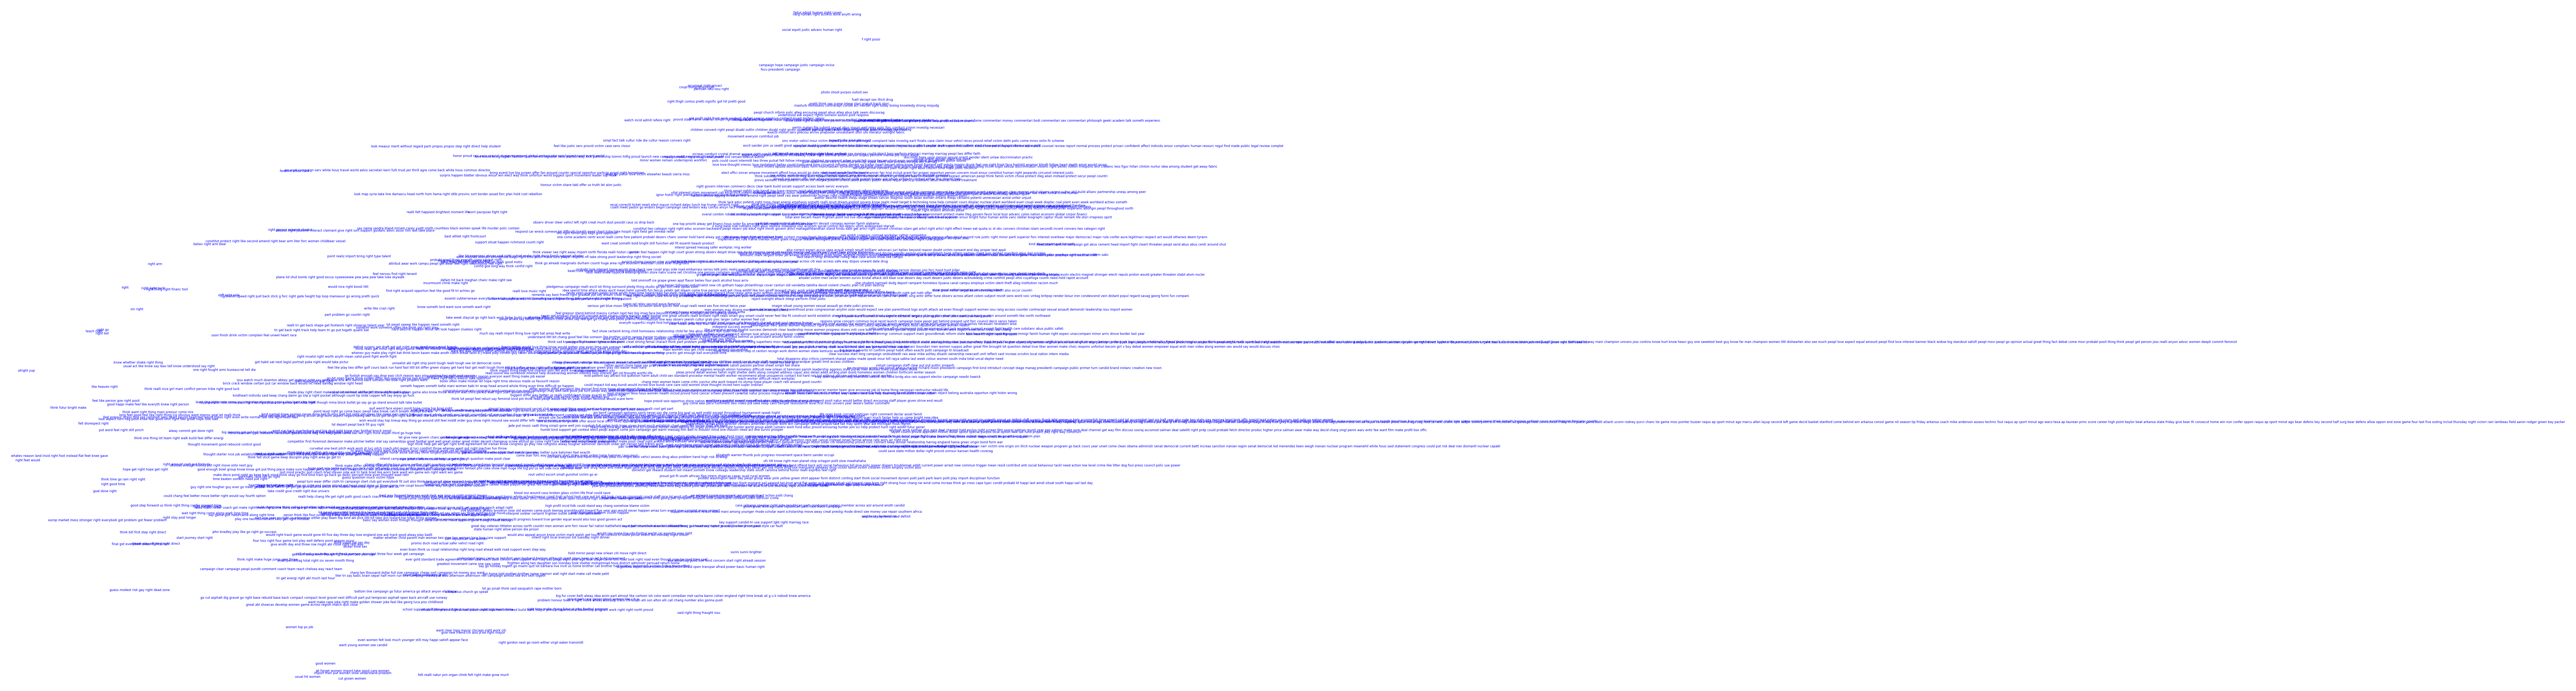

In [14]:
#Scale between 0 and 1
scaler = MinMaxScaler()
data = scaler.fit_transform(tsneDF.iloc[:, [0,1]])

tsneDF.iloc[:, [0,1]] = data
plotWords(tsneDF)

---

## <span style="color:Blue">3) Dataset Augmentation</span>

### <span style="color:Red"><div style="text-align: justify">Here, we enrich our dataset with external ones, so we explore each external dataset and apply preliminary analysis on them.</div></span>

### <span style="color:green">A- Twitter Dataset</span>

#### <span style="color:Purple"><div style="text-align: justify">The tweets dataset is acquired from [Harvard Dataverse](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/2SRSKJ) which contains 32,071,469 *metoo* tweets ranging from October 15, 2017 to March 31, 2020. The dataset only contains tweet IDs, thus, we applied for access to Twitter API in order to fetch tweets and their metadata from IDs. The dataset is distributed in 33 txt files *(each containing 1M tweet IDs)*.</div></span>

In [ ]:
#Tweet IDs paths
tweet_ids_paths = sorted(glob.glob(_DATASETS_PATHS+'/me_too_tweets/*.txt'))
print(f' There are {len(tweet_ids_paths)} files of tweet IDs')

 There are 33 files of tweet IDs


In [ ]:
#Twitter Developer keys here
#It is CENSORED
consumer_key = 'NTzTHBeXmtuLiurddtRhyvA5x'
consumer_key_secret = 'o4AhlY4tnTg4heGFSkttAa2w5CIiHhXaerckfu0sIaLAXpPEvm'
access_token = '1456399642103517184-N6FBPIuzHvj5AjUBiIaFDqlcP6kWc6'
access_token_secret = 'kOoQy5iyBd2I7ZIlo4ntPtex9lDps8KVTlvRDl3fyhHs7'

#Get access to the Twitter API to fetch tweets
auth = tweepy.OAuthHandler(consumer_key, consumer_key_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

In [ ]:
#Fetching the needed info from the api (Tweet, Location and Date)
tweets_data = ids_to_tweets('/content/drive/Shareddrives/ADA LUNATICS 2021/datasets/me_too_tweets/metoo_project_full_dataset_01.txt', api)

#### <span style="color:Purple"><div style="text-align: justify">We found that some of the IDs are not valid (user suspended/tweet deleted). Accordingly, we fetched the valid ones and saved their infos in a CSV file. As an example, we share here a small sample of the saved tweets from the first tweet IDs file.</div></span>

In [ ]:
#Loading a small sample of  tweets data that were saved after fetching
df = pd.read_csv('/content/drive/Shareddrives/ADA LUNATICS 2021/datasets/tweets_data.csv.bz2')
df = df.drop(df[df['tweet'] == 'tweet'].index)
df = df.drop(columns='Unnamed: 0')
df = df.dropna()
df.head()

,tweet,date,location
0,#Jesuits name #priests credibly accused of sex...,2018-12-17 17:47:44,"California, USA"
2,Where is NS on the #metoomovement ? Has he mad...,2018-12-17 17:00:34,"New Delhi, India"
4,RT @ColorOfChange: .@rkelly's physical and psy...,2018-12-17 16:46:43,"Brooklyn, NY"
6,@riffffffga #MeTooMovement when I’m HUNGRY,2018-12-17 16:40:29,male' Maldives
8,RT @trehan_barkha: #Reality\n#TanushreeDutta h...,2018-12-17 16:27:58,India


In [ ]:
#Extract the Year-Month from the date column to plot a timeline of the tweets
df['y-m-d'] = df['date'].apply(lambda x: str(x)[:10])
tweets_timeline = df[['y-m-d', 'tweet']].groupby(['y-m-d'], as_index=False)['tweet'].count()
tweets_timeline.head()

,y-m-d,tweet
0,2018-12-06,227
1,2018-12-07,183
2,2018-12-08,101
3,2018-12-09,80
4,2018-12-10,86


Text(0, 0.5, '# of Tweets')

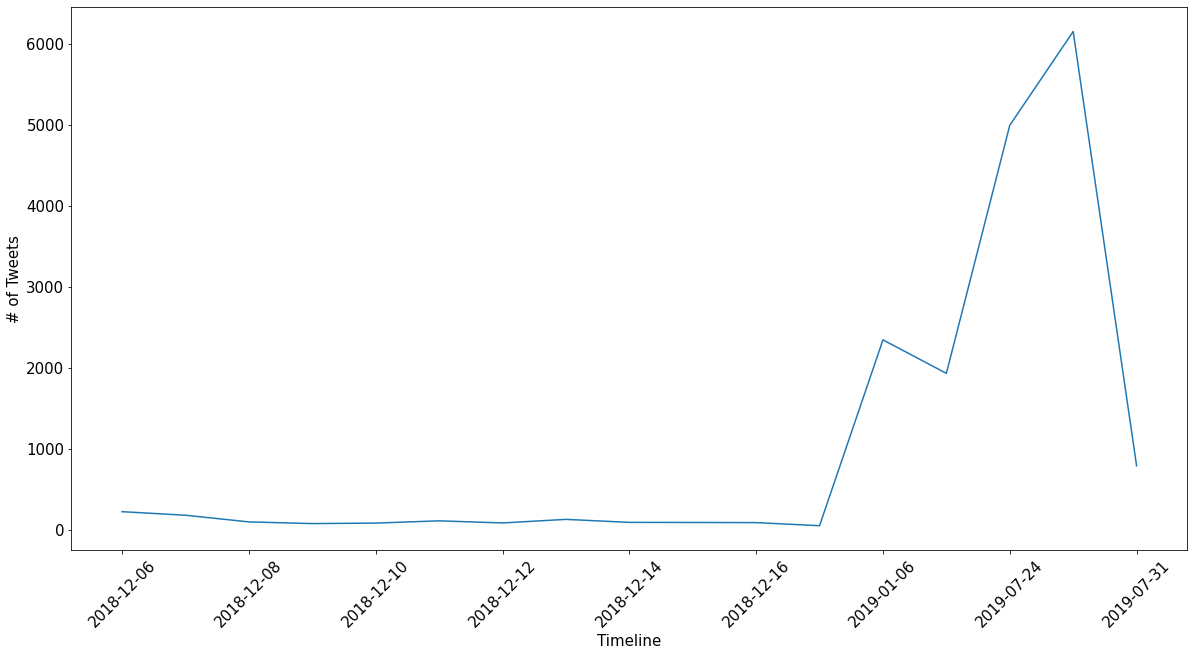

In [ ]:
#Visualizing the sample of tweets throughout time
_, axis = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
ax = sns.lineplot(x='y-m-d', y='tweet', data=tweets_timeline, ax=axis)
ax.set_xticks(tweets_timeline['y-m-d'][::2])
ax.set_xticklabels(tweets_timeline['y-m-d'][::2], rotation=45)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Timeline', fontsize=15)
ax.set_ylabel('# of Tweets', fontsize=15)

#### <span style="color:Purple"><div style="text-align: justify">The results above is not conclusive at all its just an example to show the processing/fetching/wrangling pipeline. Also, fetching the data would be ta bit time consuming because we only have limit of 180 tweets per 15 min. Accordingly, we will be processing this in parallel.</div></span>

---

### <span style="color:green">B- Traumatic Events Dataset</span>

#### <span style="color:magenta">1- Query WikiData</span>

In [ ]:
cd /content/drive/MyDrive/pywikibot_core

/content/drive/MyDrive/pywikibot_core


In [ ]:
!python pwb.py generate_user_files

fatal: bad object HEAD
You can abort at any time by pressing ctrl-c

Your default user directory is "/content/drive/MyDrive/pywikibot_core"
user-config.py already exists in the target directory "/content/drive/MyDrive/pywikibot_core".
user-password.py already exists in the target directory "/content/drive/MyDrive/pywikibot_core".
Would you like to change the directory? ([Y]es, [n]o): n


In [ ]:
import pywikibot
from pywikibot import pagegenerators as pg
import pprint as pp
from datetime import datetime

##### <span style="color:Purple"><div style="text-align: justify">The history of metoo has been defined by waves of popularity in the public discourse. These were mostly caused by events that ignited strong feelings and heated discussions into the mainstream, posing a challenge to the status quo of powerful men used to havign their ways. In this context, we define traumatic events the ones directly related to the core issue of sexual harassment, the allegations by victims and direct consequences. First, we hoped to get large and complete data about allegations and convictments of famous people by checking wikidata, where we expected to obtain enough informaiton to then select our traumatic events. The preliminary results are shown below.</div></span>

#### <span style="color:orange">Convicted of >>> sexual assault, harassment, misconduct</span> 

In [ ]:
QUERY = '''
SELECT ?item ?itemLabel
WHERE {
  ?item wdt:P1399 wd:Q673281.
  
} 
'''

# Q673281 sexual assault

prop = 'P1399' # convicted of

wikidata_site = pywikibot.Site("wikidata", "wikidata")
generator = pg.WikidataSPARQLPageGenerator(QUERY, site=wikidata_site)

counter = 0

for item in generator:
  # extracting label of the item
  labels = item.get()['labels'].toJSON()
  if 'en' in labels:
    name = labels['en']['value']
  else:
    name = labels[list(labels.keys())[0]]['value']

  pageid = item.pageid
  claim_list = item.get()["claims"][prop]
  # extract, if present, the date of the conviction
  for clm in claim_list:
    claim = clm.toJSON()
    date = None
    year = None
    if claim['mainsnak']['datavalue']['value']['numeric-id'] == 673281:
      if 'qualifiers' in claim:
        if 'P585' in claim['qualifiers']:
          date = claim['qualifiers']['P585'][0]['datavalue']['value']['time']
          year = int(date[8:12])
   
  print(name, date)  

  # count the recent ones
  if date is not None and year > 2005:
    counter = counter +1


print(counter)

Lawrence Bittaker and Roy Norris None
Richard Ramirez None
William Bonin None
Chester Turner None
Harvey Carignan None
Boris Gusakov None
Jaymes Todd +00000002019-11-00T00:00:00Z
Peter Ellis +00000001993-00-00T00:00:00Z
Anwar Raslan None
Fred West None
John Wayne Gacy Jr. None
Lawrence Adair None
Kevin Gregson None
Richard Alexander None
Rudy Guede None
Leslie Pieroni +00000002006-00-00T00:00:00Z
עזרא שיינברג None
Brendan Dassey None
David Parker Ray None
Jack Mogale None
Rosemary West None
Andrei Chikatilo +00000001992-10-14T00:00:00Z
David P. Barry +00000002021-00-00T00:00:00Z
Lawrence Bittaker None
Mark Goudeau None
Reynhard Sinaga None
Ripper Crew None
Richard Huckle None
Harvey Weinstein +00000002020-02-24T00:00:00Z
Brock Turner None
John Worboys None
Mohamed Tabet None
4


In [ ]:
QUERY = '''
SELECT ?item ?itemLabel
WHERE {
  ?item wdt:P1399 wd:Q751722.
  
} 
'''

# Q751722 sexual harassment

prop = 'P1399' # convicted of


wikidata_site = pywikibot.Site("wikidata", "wikidata")
generator = pg.WikidataSPARQLPageGenerator(QUERY, site=wikidata_site)

counter = 0

for item in generator:
  # extracting label of the item
  labels = item.get()['labels'].toJSON()
  if 'en' in labels:
    name = labels['en']['value']
  else:
    name = labels[list(labels.keys())[0]]['value']

  pageid = item.pageid
  claim_list = item.get()["claims"][prop]
  # extract, if present, the date of the conviction
  for clm in claim_list:
    claim = clm.toJSON()
    date = None
    year = None
    if claim['mainsnak']['datavalue']['value']['numeric-id'] == 751722:
      if 'qualifiers' in claim:
        if 'P585' in claim['qualifiers']:
          date = claim['qualifiers']['P585'][0]['datavalue']['value']['time']
          year = int(date[8:12])
   
  print(name, date)  

  # count the recent ones
  if date is not None and year > 2005:
    counter = counter +1


print(counter)

Yoon Chang-jung None
Moshe Katsav +00000002010-12-30T00:00:00Z
Makarov's case None
Ko Un None
1


In [ ]:
QUERY = '''
SELECT ?item ?itemLabel
WHERE {
  ?item wdt:P1399 wd:Q7458798.
  
} 
'''

# Q7458798 sexual misconduct

prop = 'P1399' # convicted of


wikidata_site = pywikibot.Site("wikidata", "wikidata")
generator = pg.WikidataSPARQLPageGenerator(QUERY, site=wikidata_site)

counter = 0

for item in generator:
  # extracting label of the item
  labels = item.get()['labels'].toJSON()
  if 'en' in labels:
    name = labels['en']['value']
  else:
    name = labels[list(labels.keys())[0]]['value']

  pageid = item.pageid
  claim_list = item.get()["claims"][prop]
  # extract, if present, the date of the conviction
  for clm in claim_list:
    claim = clm.toJSON()
    date = None
    year = None
    if claim['mainsnak']['datavalue']['value']['numeric-id'] == 7458798:
      if 'qualifiers' in claim:
        if 'P585' in claim['qualifiers']:
          date = claim['qualifiers']['P585'][0]['datavalue']['value']['time']
          year = int(date[8:12])
   
  print(name, date)  

  # count the recent ones
  if date is not None and year > 2005:
    counter = counter +1


print(counter)

6ix9ine +00000002015-00-00T00:00:00Z
1


##### <span style="color:Purple"><div style="text-align: justify">It appears that in the entire wikidata the link "convicted of" to sexual assault, harassment or misconduct is not widely represented. Only a handful of items were retrieved in all cases, without any apparent criteria linked to the popularity of the case.</div></span>

#### <span style="color:orange">Main subject / depicts >> me too movement</span>

In [ ]:
QUERY = '''
SELECT ?item 
WHERE {
  ?item wdt:P921|wdt:P180 wd:Q42133786. 

} 
'''
# main subjects / depicts metoo 
wikidata_site = pywikibot.Site("wikidata", "wikidata")
generator = pg.WikidataSPARQLPageGenerator(QUERY, site=wikidata_site)

for item in generator:
  # name of the item, in english or other language
  labels = item.get()['labels'].toJSON()
  if 'en' in labels:
    name = labels['en']['value']
  else:
    name = labels[list(labels.keys())[0]]['value']

  pageid = item.pageid
  print(name)

      
    

The Last Faust
Legitimising a Feminist Agenda
On the Record
Nous défendons une liberté d'importuner, indispensable à la liberté sexuelle
Die Sexismus-Debatte – Ändert sich jetzt etwas?
Sexismus. Oder die #MeNot-Illusion
The Last Faust (Gesamtkunstwerk)
Anne Robinson calls #metoo generation 'wusses' and reveals how colleagues used to look up her skirt but it just made her work harder as she attacks modern feminists in new show and meets the grid girls
Aziz Ansari Is Guilty. Of Not Being a Mind Reader.
Can I Enjoy the Art but Denounce the Artist?
An early, unsuccessful, attempt at #MeToo in Hollywood
discours d'Emmanuel Macron devant le Congrès des États-Unis


##### <span style="color:Purple"><div style="text-align: justify">Another attempt was made at finding all pages related to the metoo item with the main subject - depicts properties: these results mostly consist of articles and are not helpful in our search.</div></span>

#### <span style="color:orange">Subclasses of "allegations"</span>

In [ ]:
QUERY = '''
SELECT ?item 
WHERE {
  ?item wdt:P31*/wdt:P279* wd:Q2839009. 

} 
'''
# main subjects / depicts metoo 
wikidata_site = pywikibot.Site("wikidata", "wikidata")
generator = pg.WikidataSPARQLPageGenerator(QUERY, site=wikidata_site)

for item in generator:
  # name of the item, in english or other language
  labels = item.get()['labels'].toJSON()
  if 'en' in labels:
    name = labels['en']['value']
  else:
    name = labels[list(labels.keys())[0]]['value']

  pageid = item.pageid
  print(name)

      
print('\n')

QUERY = '''
SELECT ?item 
WHERE {
  ?item wdt:P279* wd:Q2839009. 

} 
'''
# main subjects / depicts metoo 
wikidata_site = pywikibot.Site("wikidata", "wikidata")
generator = pg.WikidataSPARQLPageGenerator(QUERY, site=wikidata_site)

for item in generator:
  # name of the item, in english or other language
  labels = item.get()['labels'].toJSON()
  if 'en' in labels:
    name = labels['en']['value']
  else:
    name = labels[list(labels.keys())[0]]['value']

  pageid = item.pageid
  print(name)

Aubrey de Grey sexual harassment allegations
Bill Cosby sexual assault cases
Allegations of ouster plot against Rodrigo Duterte
allegations of biological warfare in the Korean War
Franklin child prostitution ring allegations
Allegations of CIA drug trafficking
Lance Armstrong doping allegations
Заява 32-х
Donald Trump sexual misconduct allegations
Wi Spa controversy
Tawana Brawley rape allegations
allegation
Hassan Rouhani's plagiarism allegations
Joe Biden sexual assault allegation
Woody Allen sexual assault allegation
attempts to overturn the 2020 United States presidential election
Roy Moore sexual abuse allegations
Obama spying contra-Trump allegations


allegation
allegations of biological warfare in the Korean War
Donald Trump sexual misconduct allegations
Lance Armstrong doping allegations


##### <span style="color:Purple"><div style="text-align: justify">The instances of "allegations" were retrieved and do not appear to be complete.</div></span>

In [ ]:
# Properties/ items combinations tried


# Q83267 crime

# Q5801919 sex crime
 
# Q7458798 sexual misconduct
 
# Q751722 sexual harassment
 
# Q42965351 weinstein effect
 
# Q2839009 allegation
 
# Q42133786 metoo
 
# P1399 convicted of
# P361 part of
# P642 of
# P921 main subject
# P180 depicts
# P6977 review of
# instance of a sublass of wdt:P31/wdt:P279*

##### <span style="color:Purple"><div style="text-align: justify">Many more combinations of the properties and features, listed above, were tried unsuccessfully. We then decided to abandon wikidata as a primary source of traumatic events as the criteria of inclusion " the wikidata item has a specific property" did not appear to be strong enough to base our analysis on.</div></span>

#### <span style="color:magenta">2- Manual Search</span>

#### <span style="color:Purple"><div style="text-align: justify">We then looked at the literature to check how these analyses were carried out in publiched research. In both Ghosh 2020 and Kaufman 2021, the considered events were seemingly picked from the news coverage of the studied period. We set off to do the same. In our final list of traumatic events we will therefore present a selection of allegations of sexual misconduct extracted from the above mentioend papers, integrated with more updated lists such as [this](https://www.vox.com/a/sexual-harassment-assault-allegations-list?__c=1).</div></span>

#### <span style="color:Purple"><div style="text-align: justify"> Additionally, we also scraped the [website](https://www.vox.com/a/sexual-harassment-assault-allegations-list?__c=1) mentioned above since the WikiData is not sufficient in order to get the dates of alligations.

#### <span style="color:Purple"><div style="text-align: justify">Sources: [Ghosh, 2020](https://journals.sagepub.com/doi/abs/10.1177/1940161220968081) and [Kaufman, 2021](https://journals.sagepub.com/doi/abs/10.1177/0886260519868197)

In [ ]:
#Scrape the text of this URL
URL = "https://www.vox.com/a/sexual-harassment-assault-allegations-list?__c=1"
html = urlopen(URL).read()
soup = BeautifulSoup(html, features="html.parser")

#Kill all script and style elements
for script in soup(["script", "style"]):
    script.extract()    # rip it out

#Get text
text = soup.get_text()

#Break into lines and remove leading and trailing space on each
lines = (line.strip() for line in text.splitlines())
#Break multi-headlines into a line each
chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
#Drop blank lines
text = '\n'.join(chunk for chunk in chunks if chunk)
#Split the texts based on the headlines in the website
print(text.split('/ 101')[1])


Frankie Shaw
Creator and star, Showtime's SMILF
Publicly reported
December 17, 2018
Multiple staffers have said she mishandled sex scenes, and one says she took off her own shirt in a dispute over onscreen nudity.
Sources/more info:
1
1 


In [ ]:
#Another example of extracted data
print(text.split('/ 101')[4])


“I have no shame for what was done to me. I am not the one who needs to carry that shame.”
Paige Carnes, who reported that Striegel abused her
Gerard Depardieu
Actor
Publicly reported
August 30, 2018
An actress has said he raped her. French authorities are investigating.
Sources/more info:
1
2
4 


---

### <span style="color:green">C- Non-Traumatic Events Dataset</span>

#### <span style="color:magenta">1- Movie Releases</span>

#### <span style="color:magenta">2- Events/Speeches</span>

---